# Varying Width Analysis

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import Methods as m
import importlib
importlib.reload(m)

<module 'Methods' from '/Users/markzhitnitsky/Desktop/School/2025-26 Year/PHYS409/Experiment 1 - PET/Code/Methods.py'>

In [65]:

# Usage
WidthCalibrationJan14 = m.group_data_by_metric("./data/Width calibration - 2026-01-14")
# display(WidthCalibrationJan14)
WidthCalibrationJan14 = m.normalizeWidthScans(WidthCalibrationJan14)
# display(WidthCalibrationJan14)

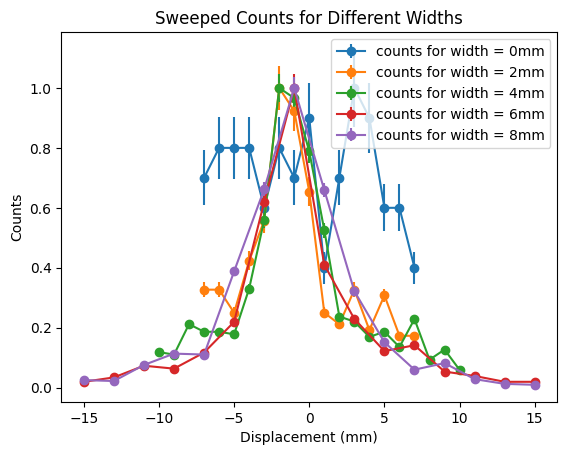

In [66]:
m.plotWidthScans(WidthCalibrationJan14, "Width Calibration Jan14")

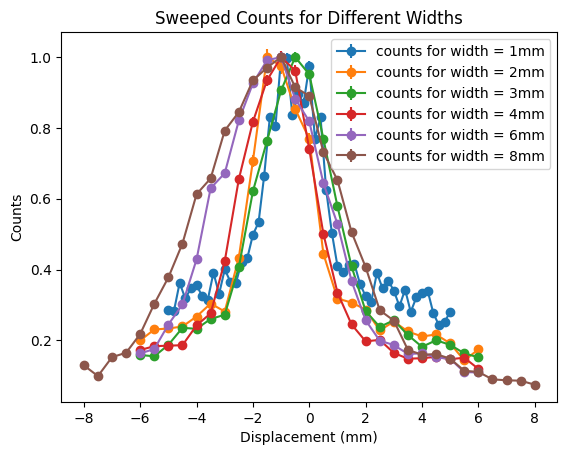

In [67]:
WidthCalibrationJan16 = m.group_data_by_metric("./data/Resolution Measurements - 2026-01-16")
WidthCalibrationJan16 = m.normalizeWidthScans(WidthCalibrationJan16)
m.plotWidthScans(WidthCalibrationJan16, "Width Calibration Jan16")

In [68]:

grouped_FWHM = m.getFWHM(WidthCalibrationJan16)
m.display_FWHM(grouped_FWHM)

with W=1, fwhm=2.803622611370648mm, from -1.9935510926300841 to 0.8100715187405639mm
with W=2, fwhm=2.770339137500179mm, from -2.360247690450424 to 0.4100914470497548mm
with W=3, fwhm=3.507755710330645mm, from -2.285572836073332 to 1.2221828742573129mm
with W=4, fwhm=3.3365970108295135mm, from -2.8333194603220178 to 0.5032775505074957mm
with W=6, fwhm=4.938379452950429mm, from -3.8378073023211785 to 1.1005721506292496mm
with W=8, fwhm=5.933490483685025mm, from -4.4099859252578275 to 1.5235045584271978mm


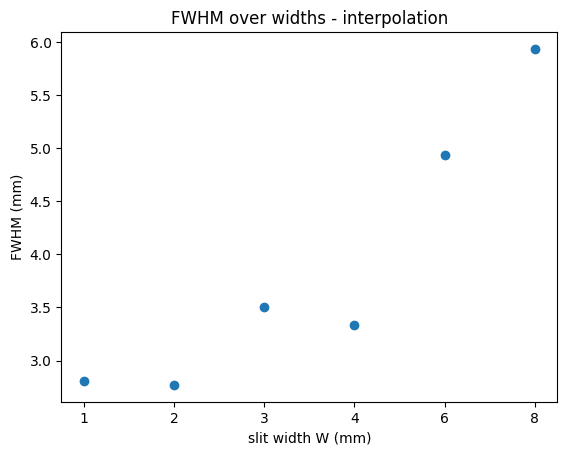

In [69]:

widths = []
fwhms = []
for width in sorted(grouped_FWHM.keys()):
    data_list = grouped_FWHM[width]

    # data_list is a list of tuples: (distance_array, counts_array)
    for fwhm, r0, r1 in data_list:
        # print(f"with W={width}, fwhm={fwhm}mm")
        # plt.scatter(width, fwhm)
        widths.append(width)
        fwhms.append(fwhm)

plt.figure()
plt.scatter(widths, fwhms)
plt.title("FWHM over widths - interpolation")
plt.xlabel("slit width W (mm)")
plt.ylabel("FWHM (mm)")
plt.savefig("figures/FWHM over slit width")
plt.show()


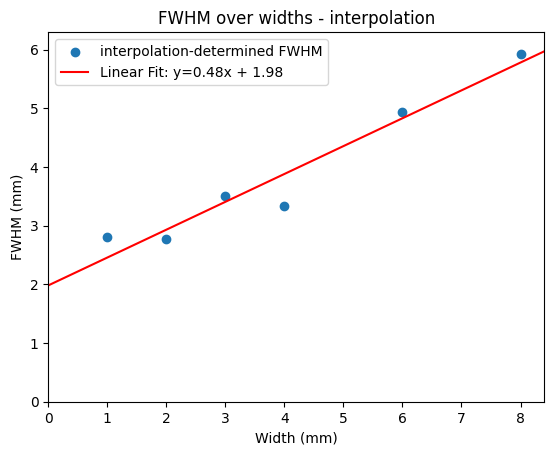

In [70]:
def linear_model(x, m, b):
    return m * x + b

widths_clean = np.array(widths, dtype=float)
fwhms_clean = np.array(fwhms, dtype=float)
# print(widths_clean)
# print(fwhms_clean)
# sorted_pairs = sorted(zip(widths_clean, fwhms_clean))
# x_sorted, y_sorted = zip(*sorted_pairs)
# print(x_sorted)
# print(y_sorted)
popt, pcov = curve_fit(linear_model, xdata=widths_clean, ydata=fwhms_clean)
m_opt, b_opt = popt
x_fit = np.linspace(0, 8.4, 100)
y_fit = linear_model(x_fit, m_opt, b_opt)

plt.figure()
plt.scatter(widths_clean, fwhms_clean, label="interpolation-determined FWHM")
plt.plot(x_fit, y_fit, 'r-', label=f"Linear Fit: y={m_opt:.2f}x + {b_opt:.2f}")

plt.xlabel("Width (mm)")
plt.ylabel("FWHM (mm)")
plt.title("FWHM over widths - interpolation")
plt.xlim(0, 8.4)
plt.ylim(0, 6.3)
plt.legend()
plt.savefig("figures/FWHM over widths with model")
plt.show()

### Now I will use gaussians
 To fit to my width-dependent scans, rather than interpolating. Then I will use a factor on sigma I get as a parameter to determine FWHM, which I can use to get uncertainty on FWHM

In [71]:
grouped_FWHM = m.getFWHMGaussian(WidthCalibrationJan16)

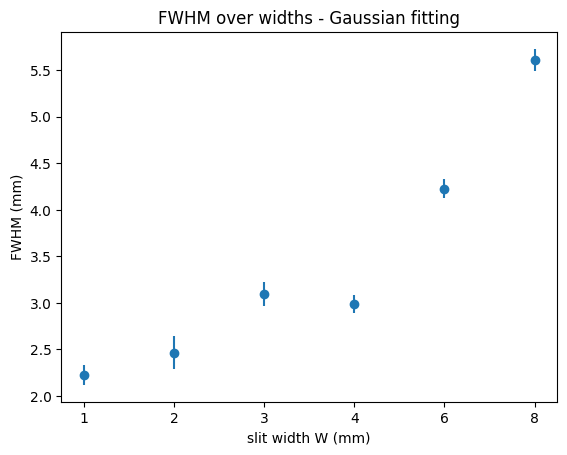

In [72]:
widths = []
fwhms = []
ufwhms = []
for width in sorted(grouped_FWHM.keys()):
    data_list = grouped_FWHM[width]

    # data_list is a list of tuples: (distance_array, counts_array)
    for fwhm, ufwhm in data_list:
        # print(f"with W={width}, fwhm={fwhm}mm")
        # plt.scatter(width, fwhm)
        widths.append(width)
        fwhms.append(fwhm)
        ufwhms.append(ufwhm)

plt.figure()
plt.errorbar(widths, fwhms, yerr=ufwhms, fmt='o')
plt.title("FWHM over widths - Gaussian fitting")
plt.xlabel("slit width W (mm)")
plt.ylabel("FWHM (mm)")
plt.savefig("figures/FWHM over slit width with uncertainty")
plt.show()


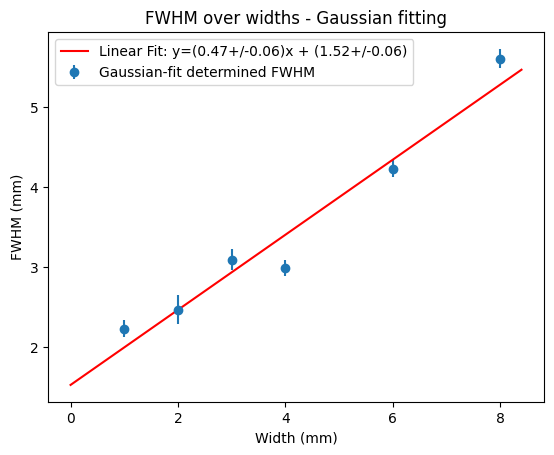

In [73]:
def linear_model(x, m, b):
    return m * x + b

widths_clean = np.array(widths, dtype=float)
fwhms_clean = np.array(fwhms, dtype=float)
ufwhms_clean = np.array(ufwhms, dtype=float)
# print(widths_clean)
# print(fwhms_clean)
# sorted_pairs = sorted(zip(widths_clean, fwhms_clean))
# x_sorted, y_sorted = zip(*sorted_pairs)
# print(x_sorted)
# print(y_sorted)
popt, pcov = curve_fit(linear_model, xdata=widths_clean, ydata=fwhms_clean, sigma=ufwhms_clean)
m_opt, b_opt = popt
um_opt = np.sqrt(pcov[0][0])
ub_opt = np.sqrt(pcov[1][1])
x_fit = np.linspace(0, 8.4, 100)
y_fit = linear_model(x_fit, m_opt, b_opt)

plt.figure()
plt.errorbar(widths_clean, fwhms_clean, yerr=ufwhms_clean, fmt='o', label="Gaussian-fit determined FWHM")
plt.plot(x_fit, y_fit, 'r-', label=f"Linear Fit: y=({m_opt:.2f}+/-{um_opt:.2f})x + ({b_opt:.2f}+/-{um_opt:.2f})")

plt.xlabel("Width (mm)")
plt.ylabel("FWHM (mm)")
plt.title("FWHM over widths - Gaussian fitting")
# plt.xlim(0, 8.4)
# plt.ylim(0, 6.3)
plt.legend()
plt.savefig("figures/FWHM over widths with uncertainty and model")
plt.show()

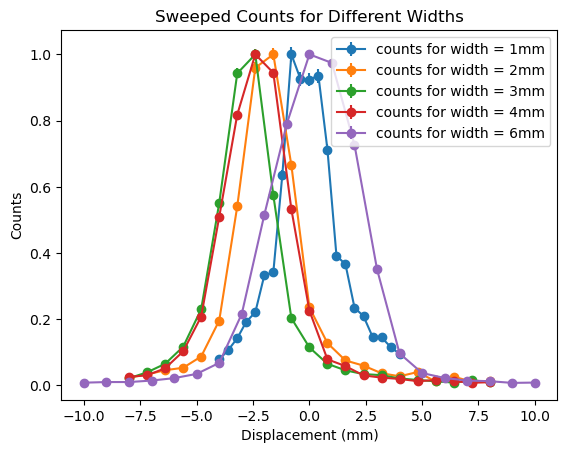

In [20]:
WidthCalibrationJan23 = m.group_data_by_metric("./data/Width calibration - 2026-01-23")
WidthCalibrationJan23 = m.normalizeWidthScans(WidthCalibrationJan23)
m.plotWidthScans(WidthCalibrationJan23, "Width Calibration Jan23")


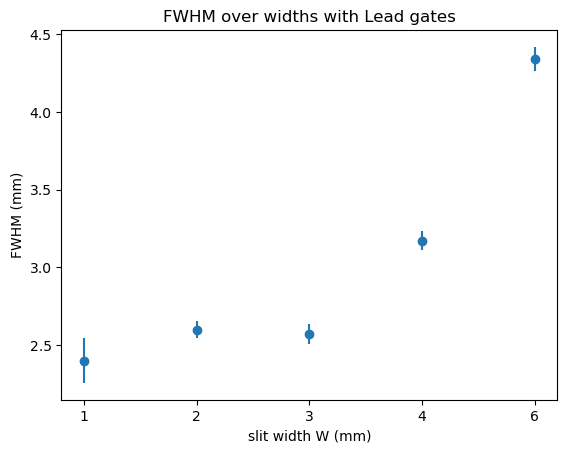

In [29]:
grouped_FWHM_jan23 = m.getFWHMGaussian(WidthCalibrationJan23)
widths = []
fwhms = []
ufwhms = []
for width in sorted(grouped_FWHM_jan23.keys()):
    data_list = grouped_FWHM_jan23[width]

    # data_list is a list of tuples: (distance_array, counts_array)
    for fwhm, ufwhm in data_list:
        # print(f"with W={width}, fwhm={fwhm}mm")
        # plt.scatter(width, fwhm)
        widths.append(width)
        fwhms.append(fwhm)
        ufwhms.append(ufwhm)

# for i,width in enumerate(widths):
#     print(width, ", ", fwhms[i], ", ", ufwhms[i])

plt.figure()
plt.errorbar(widths, fwhms, yerr=ufwhms, fmt='o')
plt.title("FWHM over widths with Lead gates")
plt.xlabel("slit width W (mm)")
plt.ylabel("FWHM (mm)")
plt.savefig("figures/FWHM over slit width with lead gates")
plt.show()


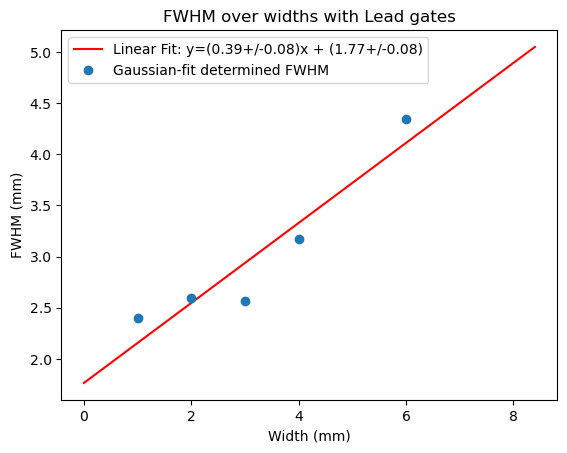

In [32]:
def linear_model(x, m, b):
    return m * x + b

widths_clean = np.array(widths, dtype=float)
fwhms_clean = np.array(fwhms, dtype=float)
ufwhms_clean = np.array(ufwhms, dtype=float)
# print(widths_clean)
# print(fwhms_clean)
# sorted_pairs = sorted(zip(widths_clean, fwhms_clean))
# x_sorted, y_sorted = zip(*sorted_pairs)
# print(x_sorted)
# print(y_sorted)
popt, pcov = curve_fit(linear_model, xdata=widths_clean, ydata=fwhms_clean) # missing , sigma=ufwhms_clean
m_opt, b_opt = popt
um_opt = np.sqrt(pcov[0][0])
ub_opt = np.sqrt(pcov[1][1])
x_fit = np.linspace(0, 8.4, 100)
y_fit = linear_model(x_fit, m_opt, b_opt)

plt.figure()
plt.errorbar(widths_clean, fwhms_clean, fmt='o', label="Gaussian-fit determined FWHM") # missing , yerr=ufwhms_clean
plt.plot(x_fit, y_fit, 'r-', label=f"Linear Fit: y=({m_opt:.2f}+/-{um_opt:.2f})x + ({b_opt:.2f}+/-{um_opt:.2f})")

plt.xlabel("Width (mm)")
plt.ylabel("FWHM (mm)")
plt.title("FWHM over widths with Lead gates")
# plt.xlim(0, 8.4)
# plt.ylim(0, 6.3)
plt.legend()
plt.savefig("figures/FWHM over widths with Lead gates")
plt.show()